# Community Challenge: Week 2 - 2022

In dit document is de [community challenge](https://community-challenge.netlify.app/) van week 2 - 2022 uitgewerkt. In deze opdracht wordt beschreven dat een machine pakjes sorteert. Er worden een aantal vragen over deze machine gesteld. Deze staan hieronder uitgewerkt. 

## Hoe ziet de data eruit?

Het aangeleverde bestand heet `pakjes.box`. Met een tekst-editor is te zien dat dit bestand regels tekst bevat. Iedere regel bestaat uit een postcode `1234AB` en het aantal pakjes. Deze is gescheiden door een spatie. De gegevens worden in een dataframe ingeladen. Als extra optie wordt meegegeven dat de `delimiter` een spatie is. Er zit geen header in de file, dus worden ook de namen van de kolommen handmatig meegegeven. 

In [116]:
import math
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

pakjes = pd.read_csv('pakjes.box', delimiter=' ',header=None, names=['postcode', 'aantal'])

pakjes.head()

,postcode,aantal
0,2405HE,17
1,3253IY,214
2,2965CB,2814
3,2187NF,2839
4,3438GC,34


## Pakjes per postcode

Elke pakketje wordt ingedeeld op postcode, zodat alle nabijgelegen adressen makkelijk in 1 keer kunnen worden verzameld. Sorteer de pakjes op de gehele postcode. Maak gebruik van een zelfgeschreven sorteerfunctie. 

In deze opdracht wordt het numerieke deel van de postcode als een extra kolom toegevoegd aan het `pakjes` dataframe. Het aantal pakjes per postcode kan dan berekend worden via `groupby` en `sum`. Het resultaat wordt omgezet van een `Series` naar een `dataFrame` en de index wordt gereset. Daarna wordt deze gesorteerd op het totale aantal per postcode.

In [117]:
# Extra kolom toevoegen aan `pakjes`, waarbij de postcode als nnnn opgeslagen wordt
pakjes["postcode_kort"] = [ int(postcode[0:4]) for postcode in pakjes.postcode ]

# Het aantal pakjes per postcode uitrekenen (groupby en dan .sum voor het aantal)
aantal_per_postcode = pakjes.groupby("postcode_kort")['aantal'].sum()

# Het resultaat is een Series, deze terug omzetten naar een dataframe
aantal_per_postcode = aantal_per_postcode.to_frame()
aantal_per_postcode.reset_index(inplace=True)

# Sorteren, hoogste aantal bovenaan
aantal_per_postcode.sort_values(by="aantal", ascending=False)

,postcode_kort,aantal
664,3443,6931
204,1752,5416
32,1125,5388
65,1283,5233
613,3245,5207
...,...,...
46,1178,20
423,2522,17
697,3576,17
179,1677,1


## Hoeveel busjes zijn er nodig?

Alle pakjes passen natuurlijk nooit in één busje. In een busje passen maximaal 50 pakjes. Om uit te rekenen hoeveel busjes nodig zijn, wordt het aantal pakjes door 50 gedeeld. Het resultaat wordt naar boven afgerond, er rijdt dan een busje rond wat niet helemaal gevuld is. Anders blijft het restant staan en dat is niet de bedoeling. Ieder busje rijdt naar een postcode.

In [118]:
busjes = (aantal_per_postcode['aantal'] / 50).apply(math.ceil)
print(f'Het totale aantal busjes wat nodig is: {busjes.sum()}')

Het totale aantal busjes wat nodig is: 23194


## Bonus

Omdat PostNL het aantal pakketjes niet meer kan bijbenen wordt er een nieuw distributiecentrum gebouwd. Er zijn verschillende adressen waar veel post naartoe gaat. In welke stad kan dit distributiecentrum het beste gebouwd worden? Zorg ervoor dat de routes die de postbezorgers vaak afleggen zo kort mogelijk zijn.

De grote vraag hierbij is natuurlijk, waar moet dit distributiecentrum geplaatst worden?

Voor deze bonusopgave wordt er vanuit gegaan dat de geleverde data representatief is voor de locatie van het distributiecentrum. Allereerst wordt een voorstelling gemaakt van waar de meeste pakjes naar toe gestuurd moeten worden. Hier komt de module [`geopandas`](https://geopandas.org/en/stable/) om de hoek kijken. Deze module maakt het gemakkelijk om met geospatial data om te gaan. De module moet wel gevoed worden met een set aan basisgegevens. Deze gegevens zijn gevonden op [PDOK](https://www.pdok.nl/), specifiek de gegevens die door het CBS verzameld zijn over de [postcodes](https://www.pdok.nl/introductie/-/article/cbs-postcode-statistieken). De gebruikte datafile is daar te downloaden. Deze is voor het gemak in deze repo toegevoegd. 

Aan de geometrie van de postcodes wordt het bovenstaande aantal pakjes toegevoegd. 

<Figure size 432x288 with 0 Axes>

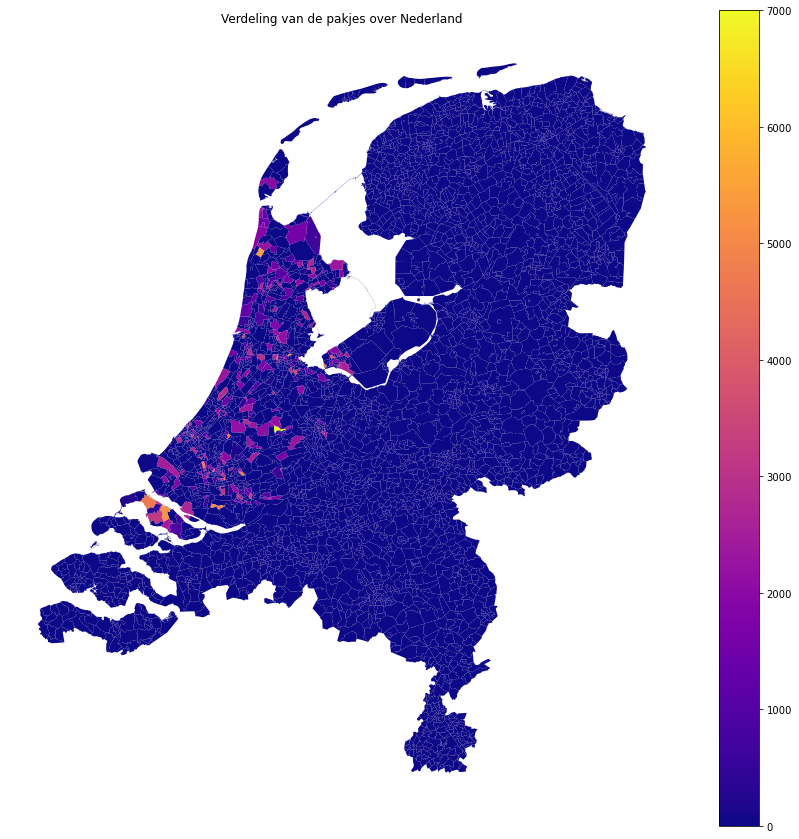

In [119]:
# Inlezen datafile
datafile = gpd.read_file('cbs_pc4_2020.gpkg')

# Alleen de postcode en geometrie wordt gebruikt
data = datafile[['postcode', 'geometry']]

# Data CBS en pakjes.box samenvoegen
data = data.merge(aantal_per_postcode, how='left', left_on='postcode', right_on='postcode_kort')
data = data.fillna(0)

# Figuur tekenen
fig = plt.figure()

p = data.plot(column='aantal', figsize = (15,15), legend=True, vmin=0, vmax=7000, cmap='plasma')
p.axis('off')
p.set_title('Verdeling van de pakjes over Nederland')
plt.savefig('pakjes.png')

Op de kaart is te zien dat de pakjes voornamelijk in Noord- en Zuid-Holland bezorgd moeten worden. Het distributiecentrum moet op de plaats komen waarbij er zo min mogelijk kilometers gereden hoeven te worden. Deze locatie wordt bij benadering uitgerekend door het gewogen gemiddelde te berekenen van de geografische positie van de te bezorgen pakketjes. 

Het gewogen gemiddelde kan als volgt beredeneerd worden: wanneer er 100 pakjes in Amsterdam bezorgd moeten worden en 1 pakje in Roermond, dan is het niet logisch om het distributiecentrum in Den Bosch te plaatsen. Een plaats vlak bij Amsterdam is dan veel handiger. Deze methode wordt hieronder uitgevoerd voor de postcodes die verzameld zijn. Voor het opzoeken van de locatie van een postcode wordt ook gebruik gemaakt van [PDOK](https://www.pdok.nl/).

In [120]:
import requests

# Opzoeken latitude en longitude van een postcode
def locatie(postcode):
    url="https://geodata.nationaalgeoregister.nl/locatieserver/v3/free"
    payload = {'q': postcode}
    r = requests.get(url, params=payload)

    try:
        locatie = r.json()["response"]["docs"][0]["centroide_ll"]

        coords = locatie.replace('POINT(', '').replace(')', '')

        lon, lat = coords.split(' ')
        
        # Opvragen duurt lang, ondertussen info laten zien
        print(f'Postcode: {postcode} lat:{lat} lon:{lon}')
        
    except IndexError:
        lat = math.nan
        lon = math.nan
    
        # Laten weten niet gevonden
        print(f'Postcode: {postcode} niet gevonden!')
    
    return {'lat': float(lat), 'lng': float(lon)}

# Zoek voor alle postcodes (uit pakjes.box) de locatie op
# Deze wordt toegevoegd aan de `data`
pakjes["locatie"] = pakjes.apply(lambda row: locatie(row["postcode"]), axis=1)


Postcode: 2405HE lat:52.13946849 lon:4.65823
Postcode: 3253IY niet gevonden!
Postcode: 2965CB lat:51.9290373 lon:4.87356863
Postcode: 2187NF niet gevonden!
Postcode: 3438GC lat:52.04571186 lon:5.08650725
Postcode: 3443EX lat:52.08813554 lon:4.86717363
Postcode: 1600JS niet gevonden!
Postcode: 3315LL niet gevonden!
Postcode: 2067EN niet gevonden!
Postcode: 2824OD niet gevonden!
Postcode: 3443EX lat:52.08813554 lon:4.86717363
Postcode: 2587GE lat:52.10966197 lon:4.28932946
Postcode: 3568YT niet gevonden!
Postcode: 3041JD lat:51.92833138 lon:4.43831202
Postcode: 2061ZJ niet gevonden!
Postcode: 3443EX lat:52.08813554 lon:4.86717363
Postcode: 3078IJ niet gevonden!
Postcode: 1971DN lat:52.46135673 lon:4.62591134
Postcode: 1414VS niet gevonden!
Postcode: 1899FE niet gevonden!
Postcode: 2804GH lat:52.03058911 lon:4.71128801
Postcode: 3574XA niet gevonden!
Postcode: 1450TO niet gevonden!
Postcode: 3202EB lat:51.85802677 lon:4.31315891
Postcode: 1093LY niet gevonden!
Postcode: 3421JD lat:52.0289

Postcode: 3443EX lat:52.08813554 lon:4.86717363
Postcode: 1987KN niet gevonden!
Postcode: 2661OP niet gevonden!
Postcode: 3135WL lat:51.92330497 lon:4.3613085
Postcode: 2326WC niet gevonden!
Postcode: 3443EX lat:52.08813554 lon:4.86717363
Postcode: 2852GN niet gevonden!
Postcode: 3483YE niet gevonden!
Postcode: 1444CX niet gevonden!
Postcode: 1661DJ niet gevonden!
Postcode: 2405HE lat:52.13946849 lon:4.65823
Postcode: 2398HB niet gevonden!
Postcode: 2737GH niet gevonden!
Postcode: 1719SP niet gevonden!
Postcode: 1498AZ niet gevonden!
Postcode: 3443EX lat:52.08813554 lon:4.86717363
Postcode: 2795IU niet gevonden!
Postcode: 1389VB niet gevonden!
Postcode: 1080GF niet gevonden!
Postcode: 1878AD niet gevonden!
Postcode: 2405HE lat:52.13946849 lon:4.65823
Postcode: 1361ZS niet gevonden!
Postcode: 1142IV niet gevonden!
Postcode: 3342MZ niet gevonden!
Postcode: 2206UQ niet gevonden!
Postcode: 3421JD lat:52.02894053 lon:4.86890419
Postcode: 1195VS niet gevonden!
Postcode: 2418TK niet gevonden!

Postcode: 2405HE lat:52.13946849 lon:4.65823
Postcode: 3251IQ niet gevonden!
Postcode: 1224KF niet gevonden!
Postcode: 2204ZI niet gevonden!
Postcode: 3267UT niet gevonden!
Postcode: 2405HE lat:52.13946849 lon:4.65823
Postcode: 1235IM niet gevonden!
Postcode: 3580KF niet gevonden!
Postcode: 1784HB niet gevonden!
Postcode: 2729AM lat:52.06475228 lon:4.52877804
Postcode: 2804GH lat:52.03058911 lon:4.71128801
Postcode: 1140RY niet gevonden!
Postcode: 2391EM lat:52.09250406 lon:4.58736825
Postcode: 2514LV lat:52.08813116 lon:4.31080463
Postcode: 2164KI niet gevonden!
Postcode: 2804GH lat:52.03058911 lon:4.71128801
Postcode: 2069EI niet gevonden!
Postcode: 3288IN niet gevonden!
Postcode: 2464TJ niet gevonden!
Postcode: 1554NT niet gevonden!
Postcode: 3421JD lat:52.02894053 lon:4.86890419
Postcode: 2407PX niet gevonden!
Postcode: 2952XM niet gevonden!
Postcode: 3244MY niet gevonden!
Postcode: 2937ML niet gevonden!
Postcode: 3421JD lat:52.02894053 lon:4.86890419
Postcode: 1838BY niet gevonden

Postcode: 2794YI niet gevonden!
Postcode: 2444DP niet gevonden!
Postcode: 2175UZ niet gevonden!
Postcode: 1475DC niet gevonden!
Postcode: 3421JD lat:52.02894053 lon:4.86890419
Postcode: 1993AG niet gevonden!
Postcode: 1527QZ niet gevonden!
Postcode: 2960XC niet gevonden!
Postcode: 1699ML niet gevonden!
Postcode: 3443EX lat:52.08813554 lon:4.86717363
Postcode: 1021SO niet gevonden!
Postcode: 1683IZ niet gevonden!
Postcode: 3445BU niet gevonden!
Postcode: 1986LY niet gevonden!
Postcode: 3421JD lat:52.02894053 lon:4.86890419
Postcode: 1830HV niet gevonden!
Postcode: 3371YW niet gevonden!
Postcode: 2123WC niet gevonden!
Postcode: 2635HJ lat:52.00196074 lon:4.33089098
Postcode: 2405HE lat:52.13946849 lon:4.65823
Postcode: 3551MT niet gevonden!
Postcode: 2702DW niet gevonden!
Postcode: 2151VU niet gevonden!
Postcode: 2434GD niet gevonden!
Postcode: 3421JD lat:52.02894053 lon:4.86890419
Postcode: 1644PG niet gevonden!
Postcode: 3388UZ niet gevonden!
Postcode: 3061RP lat:51.92545406 lon:4.5005

Postcode: 1064VN lat:52.37799226 lon:4.81372072
Postcode: 2169TE niet gevonden!
Postcode: 1063QI niet gevonden!
Postcode: 3443EX lat:52.08813554 lon:4.86717363
Postcode: 1848OA niet gevonden!
Postcode: 3011XM lat:51.91647193 lon:4.48691965
Postcode: 3168CO niet gevonden!
Postcode: 1228PB niet gevonden!
Postcode: 2804GH lat:52.03058911 lon:4.71128801
Postcode: 2468AZ niet gevonden!
Postcode: 1105OB niet gevonden!
Postcode: 2525TK niet gevonden!
Postcode: 1944QJ niet gevonden!
Postcode: 3421JD lat:52.02894053 lon:4.86890419
Postcode: 2522ED lat:52.0602436 lon:4.32733101
Postcode: 1522FM niet gevonden!
Postcode: 3071OL niet gevonden!
Postcode: 3474UA niet gevonden!
Postcode: 3443EX lat:52.08813554 lon:4.86717363
Postcode: 1176YI niet gevonden!
Postcode: 2127GB niet gevonden!
Postcode: 2313TY niet gevonden!
Postcode: 3018KM niet gevonden!
Postcode: 3443EX lat:52.08813554 lon:4.86717363
Postcode: 1310SA niet gevonden!
Postcode: 1409AP niet gevonden!
Postcode: 1179FU niet gevonden!
Postcode:

Helaas wordt voor een aantal postcodes geen locatie gevonden (bestemming onbekend). Dit is wel te verwachten met een (fictieve?) dataset. Desalniettemin wordt het gewogen gemiddelde punt berekend.


In [121]:
# Uitpakken van de net verzamelde dict naar aparte kolommen lat en lng
pakjes["lat"] = pakjes.apply(lambda row: row["locatie"]["lat"], axis=1)
pakjes["lng"] = pakjes.apply(lambda row: row["locatie"]["lng"], axis=1)

# Wegfilteren van de NaN meldingen
pakjes_bekend = pakjes.dropna()

# Gewogen som uitrekenen
lat_sum = (pakjes_bekend["aantal"] * pakjes_bekend["lat"]).sum()
lng_sum = (pakjes_bekend["aantal"] * pakjes_bekend["lng"]).sum()
n = (pakjes_bekend["aantal"]).sum()

# Gemiddelde locatie uitrekenen
locatie_lat = lat_sum / n
locatie_lng = lng_sum / n

#print(f'lat: {lat_sum}, lng: {lng_sum}, n: {n}')
print(f'Locatie gevonden: {locatie_lat:0.7f}, {locatie_lng:0.7f}')


Locatie gevonden: 52.2054799, 4.6868777


Nu de ideale locatie bekend is, kan deze op de [kaart](https://www.google.com/maps/place/52%C2%B012'19.7%22N+4%C2%B041'12.8%22E/@52.2323425,4.5866771,10.38z/data=!4m5!3m4!1s0x0:0x5f3846d0cccb1877!8m2!3d52.20548!4d4.68688) opgezocht worden. Voor de liefhebbers: de gewenste locatie is **Roelofarendsveen**. Deze plaats ligt ook fijn bereikbaar langs de A4. 

Het is natuurlijk mooier om deze in bovenstaand figuur in te tekenen. De geometrie van de kaart is opgeslagen in rijkscoördinaten en helaas niet in GPS-coördinaten. De boven verkregen locatie is [hier](https://www.gpscoordinaten.nl/converteer-rd-coordinaten.php) omgerekend. 

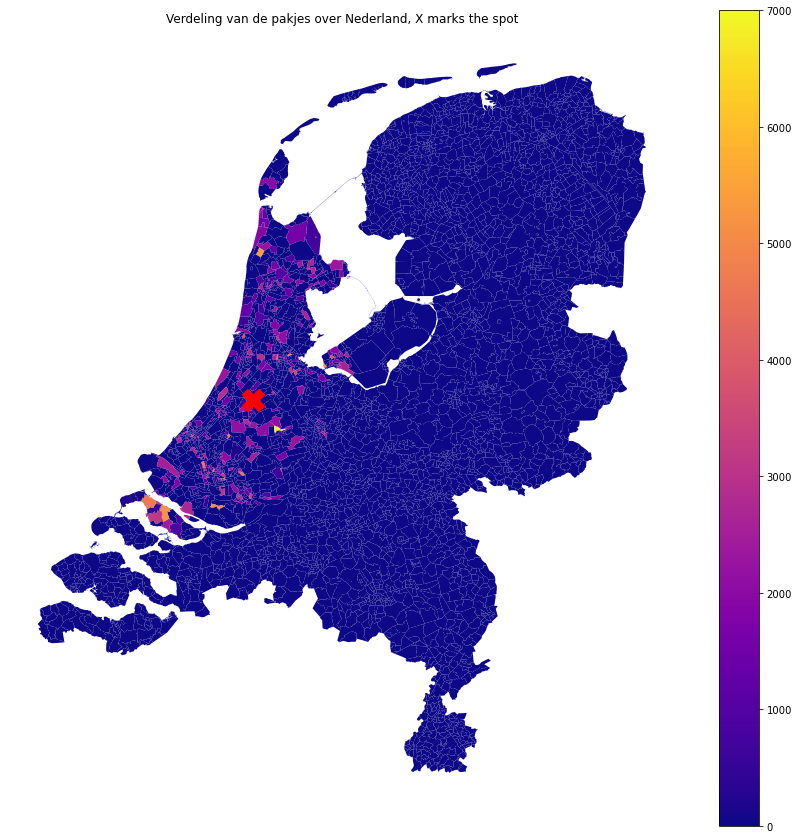

In [122]:
from shapely.geometry import Point

# Locatie distributiecentrum als tweede dataframe aanmaken, met geo-info
locatie = pd.DataFrame({'lat': [locatie_lat], 'lng': [locatie_lng]}, columns=['lat', 'lng'])
locatie_point = [Point([107128, 468828])]
locatie = gpd.GeoDataFrame(locatie, geometry=locatie_point)

# Figuur tekenen
fig, ax = plt.subplots()
fig.set_size_inches(15,15)
ax.set_aspect('equal')

p = data.plot(column='aantal', figsize = (15,15), legend=True, vmin=0, vmax=7000, cmap='plasma', ax=ax)
p.axis('off')
p.set_title('Verdeling van de pakjes over Nederland, X marks the spot')

l = locatie.plot(ax=ax, markersize=500, marker='X', color='red')

plt.savefig('pakjes_met_locatie.png')